# 1. Load Data

In [1]:
# Summaary data set

# Load data
import os
import pandas as pd
import glob
import json
import numpy as np
import seaborn as sns
import gc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import BallTree
from sklearn.metrics import confusion_matrix
import tqdm
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Confirm the current working directory
print("Current working directory:", os.getcwd())

2025-07-02 11:18:06.691061: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-02 11:18:08.511190: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Current working directory: /home/qusta100/Gasoline


In [2]:
# Load data (restore from saved file)
recovery = pd.read_csv("Data/Temp/final.csv")

In [3]:
recovery.head()

,date,station_uuid,diesel,e5,e10,uuid,name,brand,post_code,latitude,...,rank_e5_5km+7,rank_e5_5km+8,rank_e10_5km+1,rank_e10_5km+2,rank_e10_5km+3,rank_e10_5km+4,rank_e10_5km+5,rank_e10_5km+6,rank_e10_5km+7,rank_e10_5km+8
0,2025-04-01 00:00:00,00006210-0037-4444-8888-acdc00006210,1.649,1.779,1.719,00006210-0037-4444-8888-acdc00006210,Beducker - Qualität günstig tanken,Beducker,86405,48.555683,...,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,2025-04-01 00:15:00,00006210-0037-4444-8888-acdc00006210,1.649,1.779,1.719,00006210-0037-4444-8888-acdc00006210,Beducker - Qualität günstig tanken,Beducker,86405,48.555683,...,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,2025-04-01 00:30:00,00006210-0037-4444-8888-acdc00006210,1.649,1.779,1.719,00006210-0037-4444-8888-acdc00006210,Beducker - Qualität günstig tanken,Beducker,86405,48.555683,...,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,2025-04-01 00:45:00,00006210-0037-4444-8888-acdc00006210,1.649,1.779,1.719,00006210-0037-4444-8888-acdc00006210,Beducker - Qualität günstig tanken,Beducker,86405,48.555683,...,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,2025-04-01 01:00:00,00006210-0037-4444-8888-acdc00006210,1.649,1.779,1.719,00006210-0037-4444-8888-acdc00006210,Beducker - Qualität günstig tanken,Beducker,86405,48.555683,...,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [4]:
# List all variables (columns)
print(recovery.columns.tolist())

# Print total number of observations (rows)
print(len(recovery))

# Print number of unique station_uuid values
print(recovery['station_uuid'].nunique())

['date', 'station_uuid', 'diesel', 'e5', 'e10', 'uuid', 'name', 'brand', 'post_code', 'latitude', 'longitude', 'day', 'last_seen', 'is_open', 'rank_diesel_5km', 'rank_e5_5km', 'rank_e10_5km', 'rank_diesel_5km+1', 'rank_diesel_5km+2', 'rank_diesel_5km+3', 'rank_diesel_5km+4', 'rank_diesel_5km+5', 'rank_diesel_5km+6', 'rank_diesel_5km+7', 'rank_diesel_5km+8', 'rank_e5_5km+1', 'rank_e5_5km+2', 'rank_e5_5km+3', 'rank_e5_5km+4', 'rank_e5_5km+5', 'rank_e5_5km+6', 'rank_e5_5km+7', 'rank_e5_5km+8', 'rank_e10_5km+1', 'rank_e10_5km+2', 'rank_e10_5km+3', 'rank_e10_5km+4', 'rank_e10_5km+5', 'rank_e10_5km+6', 'rank_e10_5km+7', 'rank_e10_5km+8']
43320521
15093


# 2. Graphs

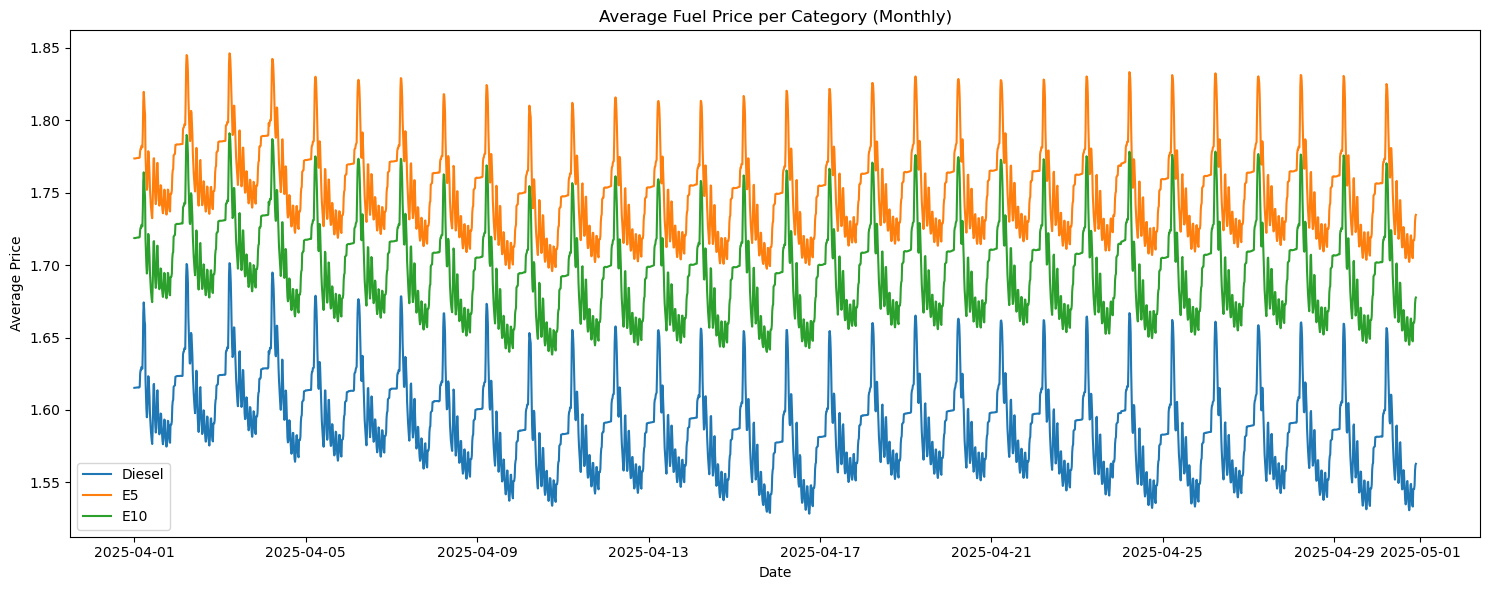

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'date' column to datetime if not already done
recovery['date'] = pd.to_datetime(recovery['date'])

# Group by timestamp and calculate mean prices
avg_prices = recovery.groupby('date')[['diesel', 'e5', 'e10']].mean()

# Create plot
plt.figure(figsize=(15, 6))
plt.plot(avg_prices.index, avg_prices['diesel'], label='Diesel')
plt.plot(avg_prices.index, avg_prices['e5'], label='E5')
plt.plot(avg_prices.index, avg_prices['e10'], label='E10')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Fuel Price per Category (Monthly)')
plt.legend()
plt.tight_layout()
plt.savefig("graphs/price_month.png")
plt.show()

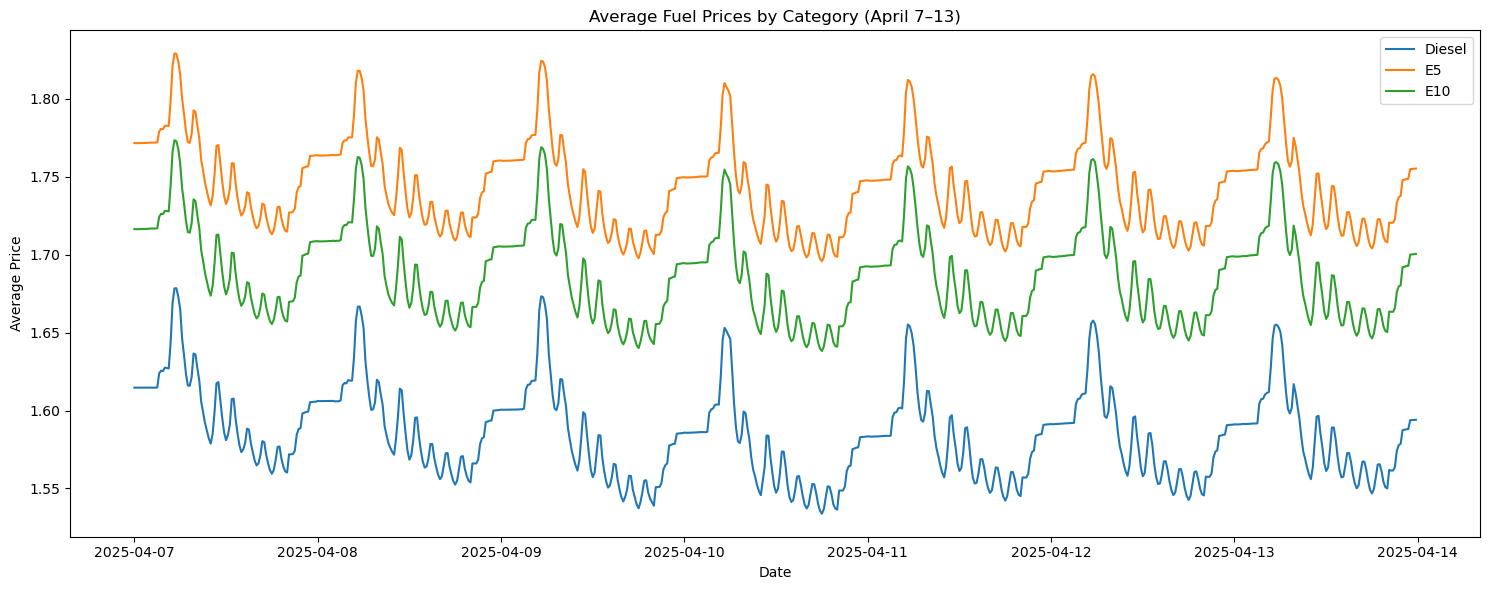

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'date' column to datetime
recovery['date'] = pd.to_datetime(recovery['date'])

# Select time range: April 7 to April 13
start = pd.Timestamp('2025-04-07')
end = pd.Timestamp('2025-04-13 23:59:59')
mask = (recovery['date'] >= start) & (recovery['date'] <= end)
subset = recovery.loc[mask]

# Group by timestamp and calculate mean prices
avg_prices = subset.groupby('date')[['diesel', 'e5', 'e10']].mean()

# Plot
plt.figure(figsize=(15, 6))
plt.plot(avg_prices.index, avg_prices['diesel'], label='Diesel')
plt.plot(avg_prices.index, avg_prices['e5'], label='E5')
plt.plot(avg_prices.index, avg_prices['e10'], label='E10')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Fuel Prices by Category (April 7–13)')
plt.legend()
plt.tight_layout()
plt.savefig("graphs/price_week.png")
plt.show()

# 3. Tables

In [8]:
# Assumption: 'recovery' already contains the data
recovery = recovery.sort_values(['station_uuid', 'date'])

# Create change indicator columns: 1 if the price changes compared to the previous observation at the same station
recovery['change_diesel'] = recovery.groupby('station_uuid')['diesel'].diff().ne(0).astype(int)
recovery['change_e5']     = recovery.groupby('station_uuid')['e5'].diff().ne(0).astype(int)
recovery['change_e10']    = recovery.groupby('station_uuid')['e10'].diff().ne(0).astype(int)

# Extract only the date part (without time)
recovery['day'] = recovery['date'].dt.date

# Sum the number of changes per station and day
daily_changes = recovery.groupby(['station_uuid', 'day'])[['change_diesel', 'change_e5', 'change_e10']].sum().reset_index()

# Print min, average, and max number of changes per fuel type
for fuel in ['change_diesel', 'change_e5', 'change_e10']:
    print(f"--- {fuel.upper()} ---")
    print('min:', daily_changes[fuel].min())
    print('avg:', daily_changes[fuel].mean())
    print('max:', daily_changes[fuel].max())

# Summary statistics (min, mean, max) for all fuel types
# Summary statistics (min, mean, max) for all fuel types
summary = daily_changes[['change_diesel', 'change_e5', 'change_e10']].agg(['min', 'mean', 'max'])
print(summary)

--- CHANGE_DIESEL ---
min: 0
avg: 40.08837781760088
max: 96
--- CHANGE_E5 ---
min: 0
avg: 41.68133074949675
max: 96
--- CHANGE_E10 ---
min: 0
avg: 44.38741418208093
max: 96
      change_diesel  change_e5  change_e10
min        0.000000   0.000000    0.000000
mean      40.088378  41.681331   44.387414
max       96.000000  96.000000   96.000000


In [9]:
# Sort data by station and timestamp
recovery = recovery.sort_values(['station_uuid', 'date'])

# Compute price differences compared to previous observation at the same station
recovery['diff_diesel'] = recovery.groupby('station_uuid')['diesel'].diff()
recovery['diff_e5']     = recovery.groupby('station_uuid')['e5'].diff()
recovery['diff_e10']    = recovery.groupby('station_uuid')['e10'].diff()

# Dictionary to store results
results = {}

# Loop over fuel types and calculate statistics for price increases and decreases
for fuel, diff_col in [('diesel', 'diff_diesel'), ('e5', 'diff_e5'), ('e10', 'diff_e10')]:
    decrease = recovery[recovery[diff_col] < 0][diff_col]
    increase = recovery[recovery[diff_col] > 0][diff_col]
    
    results[fuel] = {
        'decrease_min': decrease.min(),
        'decrease_max': decrease.max(),
        'decrease_avg': decrease.mean(),
        'increase_min': increase.min(),
        'increase_max': increase.max(),
        'increase_avg': increase.mean()
    }

# Display results nicely as DataFrame
df_results = pd.DataFrame(results).T
print(df_results)


        decrease_min  decrease_max  decrease_avg  increase_min  increase_max  \
diesel        -3.000        -0.001     -0.023338         0.001         2.980   
e5            -2.725        -0.001     -0.022691         0.001         2.725   
e10           -2.705        -0.001     -0.022745         0.001         2.705   

        increase_avg  
diesel      0.042235  
e5          0.041380  
e10         0.041190  


In [10]:
# Select only the desired time period (e.g., April 7–13)
start = pd.Timestamp('2025-04-07')
end = pd.Timestamp('2025-04-13 23:59:59')
subset = recovery[(recovery['date'] >= start) & (recovery['date'] <= end)]

# Min, Max, and Average for each fuel type
summary = subset[['diesel', 'e5', 'e10']].agg(['min', 'max', 'mean'])
print(summary)


        diesel        e5      e10
min   1.199000  1.549000  1.16800
max   3.000000  4.444000  3.33300
mean  1.580215  1.738063  1.68083


In [11]:
import numpy as np
from sklearn.neighbors import BallTree

# All gas station coordinates
coords = recovery[['latitude', 'longitude']].drop_duplicates().to_numpy()
coords_rad = np.deg2rad(coords)  # BallTree requires radians

# Build BallTree
tree = BallTree(coords_rad, metric='haversine')

# Radii in kilometers (Earth radius ~6371 km)
radii_km = [3, 5, 10]
radii_rad = [r / 6371 for r in radii_km]  # Convert km to radians

neighbor_counts = {}

for r_km, r_rad in zip(radii_km, radii_rad):
    # For each coordinate: number of neighbors within the radius (including itself!)
    ind = tree.query_radius(coords_rad, r=r_rad)
    n_neighbors = np.array([len(x) - 1 for x in ind])  # subtract 1 because a station matches itself
    neighbor_counts[r_km] = {
        'min': n_neighbors.min(),
        'avg': n_neighbors.mean(),
        'max': n_neighbors.max()
    }

# Output
for r in radii_km:
    print(f"{r} km --- min: {neighbor_counts[r]['min']}, avg: {neighbor_counts[r]['avg']:.2f}, max: {neighbor_counts[r]['max']}")


3 km --- min: 0, avg: 4.53, max: 33
5 km --- min: 0, avg: 9.80, max: 59
10 km --- min: 0, avg: 29.89, max: 157
